In [2]:
import pandas as pd
# covid_data — данные о показателях заболеваемости за каждый день в различных регионах 187 стран. 
covid_data = pd.read_csv('data/covid_data.csv')
display(covid_data.head())

,date,province/state,country,confirmed,deaths,recovered
0,01/22/2020,Anhui,China,1.0,0.0,0.0
1,01/22/2020,Beijing,China,14.0,0.0,0.0
2,01/22/2020,Chongqing,China,6.0,0.0,0.0
3,01/22/2020,Fujian,China,1.0,0.0,0.0
4,01/22/2020,Gansu,China,0.0,0.0,0.0


## Мы будем работать со следующими столбцами:

- date — дата наблюдения;
- province/state — наименование провинции/штата;
- country — наименование страны;
- confirmed — общее число зафиксированных случаев на указанный день;
- deaths — общее число зафиксированных смертей на указанный день;
- recovered — общее число выздоровлений на указанный день.

In [3]:
# country_vaccinations — данные о процессе вакцинирования людей в 221 стране мира.

# Обратите внимание, что в приведённом источнике https://www.kaggle.com/gpreda/covid-world-vaccination-progress данные о вакцинации постоянно обновляются. В данном модуле будет использоваться файл, который мы скачали заранее.

vaccinations_data = pd.read_csv('data/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]

## Данная таблица содержит следующие столбцы:

- country — наименование страны;
- date — дата наблюдения;
- total_vaccinations — общее число введённых вакцин в стране на указанный день;
- people_vaccinated — общее число привитых первым компонентом в стране на указанный день;
- people_vaccinated_per_hundred — процент привитых первым компонентом в стране на указанный день (рассчитывается как );
- people_fully_vaccinated — общее число привитых вторым компонентом в стране на указанный день (первый компонент уже был введён им ранее);
- people_fully_vaccinated_per_hundred — процент привитых вторым компонентом в стране на указанный день (рассчитывается как );
- daily_vaccination — ежедневная вакцинация (число вакцинированных в указанный день);
- vaccines — комбинации вакцин, используемые в стране.

В данных много пропусков, а также неверно введённых значений. Например, для США (United States) и Великобритании (United Kingdom) в большинстве записей таблицы covid_data число выздоровевших людей равно 0. В данном модуле мы закроем на это глаза, но вообще эти страны подлежали бы исключению из данных или нам понадобился бы дополнительный источник данных, из которого мы смогли бы получить недостающую информацию.

Обратите внимание, что признаки confirmed, deaths, recovered, total_vaccination, people_vaccinated, people_fully_vaccinated — это суммарные показатели по стране, то есть с каждым днём они должны расти. Такие признаки называют накопительными.

Возникает большое желание объединить таблицы. Для этого необходимо учитывать следующие нюансы:

1. В таблице covid_data необходимо предварительно рассчитать суммарное ежедневное число заболевших во всех провинциях/штатах в каждой стране.
2. В таблицах не совпадает число стран, а иногда и их названия. 
При объединении таблиц по столбцу мы определённо теряем данные (в данной задаче потери незначительны). Избежать этого можно ручными преобразованиями данных — искать различия в названиях стран в таблицах и преобразовывать их. Однако это не является темой данного модуля.

3.Таблицы имеют разные периоды наблюдений (вакцины появились позже, чем сам вирус). Объединив данные с типом inner, мы можем потерять большое количество наблюдений в таблице covid_data.

## ПРЕДОБРАБОТКА ДАННЫХ

Опираясь на замечания выше, выполним небольшую предобработку.

В таблице covid_data:

1. Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. Тем самым переходим от данных по регионам к данным по странам:

In [4]:
covid_data = covid_data.groupby(
    ['date', 'country'],
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()
covid_data

,date,country,confirmed,deaths,recovered
0,01/01/2021,Afghanistan,51526.0,2191.0,41727.0
1,01/01/2021,Albania,58316.0,1181.0,33634.0
2,01/01/2021,Algeria,99897.0,2762.0,67395.0
3,01/01/2021,Andorra,8117.0,84.0,7463.0
4,01/01/2021,Angola,17568.0,405.0,11146.0
...,...,...,...,...,...
86780,12/31/2020,Vietnam,1465.0,35.0,1325.0
86781,12/31/2020,West Bank and Gaza,138004.0,1400.0,117183.0
86782,12/31/2020,Yemen,2099.0,610.0,1394.0
86783,12/31/2020,Zambia,20725.0,388.0,18660.0


2. Преобразуем даты в формат datetime с помощью функции pd.to_datetime():

In [5]:
covid_data['date'] = pd.to_datetime(covid_data['date'])

3. Создадим признак больных на данный момент (active). Для этого вычтем из общего числа зафиксированных случаев число смертей и число выздоровевших пациентов:

In [6]:
covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

4. Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей. Для этого отсортируем данные по названиям стран, а затем по датам. После этого произведём группировку по странам и рассчитаем разницу между «вчера и сегодня» с помощью метода diff():

In [7]:
covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()
display(covid_data)

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered
11337,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN
11570,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
11807,2020-02-26,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12051,2020-02-27,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
12299,2020-02-28,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
15933,2020-03-12,occupied Palestinian territory,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16595,2020-03-14,occupied Palestinian territory,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16938,2020-03-15,occupied Palestinian territory,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17290,2020-03-16,occupied Palestinian territory,0.0,0.0,0.0,0.0,0.0,0.0,0.0


В таблице vaccinations_data достаточно будет преобразовать столбцы в формат datetime:

In [8]:
vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

### Задание 3.1
За какой период представлены данные в таблице covid_data? В качестве ответа введите даты в формате datetime (без указания времени).
Введите ответ в следующем формате (без пробелов): ГГГГ-ММ-ДД-ГГГГ-ММ-ДД

In [9]:
min_date = covid_data['date'].min().date()
max_date = covid_data['date'].max().date()
print(f'{min_date}-{max_date}')
# print(covid_data['date'].min().date(),'-',covid_data['date'].max().date())
# covid_data['date'].date.max()
# print(covid_data['date'].max())

2020-01-22-2021-05-29


### Задание 3.2
За какой период представлены данные в таблице vaccinations_data? В качестве ответа введите даты в формате datetime без указания времени.
Введите ответ через дефис (например, 2020-01-01-2021-01-01).

In [11]:
print(f"{vaccinations_data['date'].min().date()}-{vaccinations_data['date'].max().date()}")


2020-12-02-2021-09-06


### Задание 3.3
С помощью метода merge() объедините таблицы covid_data и vaccinations_data по столбцам date и country.
Тип объединения выставьте так, чтобы в результирующую таблицу попали только наблюдения за период, вычисленный в задании 3.1. То есть в результирующую таблицу должны попасть все записи из таблицы covid_data и из её пересечения с vaccinations_data, но не более. Результат объединения занесите в переменную covid_df.
Сохраните таблицу covid_df — она понадобится нам в следующем юните.

Сколько строк и столбцов в таблице covid_df?
Введите ответ в виде двух чисел через дефис (например, 333-33): первое число — количество строк, второе число — количество столбцов.

In [14]:
covid_df = covid_data.merge(
    vaccinations_data,
    on=['date', 'country'],
    how='left'    
)
display(covid_df.shape)

(86785, 16)

В получившейся в задании 3.3 таблице covid_df создайте признаки death_rate — общий процент смертей среди зафиксированных случаев (летальность) и recover_rate — общий процент случаев выздоровления. Данные характеристики рассчитайте как отношение числа смертей (deaths) и числа выздоровлений (recovered) к числу зафиксированных случаев (confirmed) и умножьте результаты на 100%.

In [15]:
covid_df['death_rate'] = (covid_df['deaths']/covid_df['confirmed']) * 100 
covid_df['recover_rate'] = (covid_df['recovered']/covid_df['confirmed']) * 100

In [19]:
covid_df.head()

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines,death_rate,recover_rate
0,2020-02-24,Afghanistan,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,2020-02-25,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,2020-02-26,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,2020-02-27,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,2020-02-28,Afghanistan,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


### Задание 3.4
Какова максимальная летальность в США (United States) за весь период? Ответ округлите до второго знака после запятой.

In [25]:
round(covid_df[covid_df['country'] == 'United States']['death_rate'].max(),2)

7.19

In [27]:
round(covid_df[covid_df['country'] == 'Russia']['death_rate'].max(),2)

2.38

### Задание 3.5
Чему равен средний процент выздоровевших в России (Russia)? Ответ округлите до второго знака после запятой.

In [26]:
round(covid_df[covid_df['country'] == 'Russia']['recover_rate'].mean(),2)

67.06

In [28]:
round(covid_df[covid_df['country'] == 'United States']['recover_rate'].mean(),2)

16.33

# 4. Графические возможности библиотеки Pandas
## БАЗОВАЯ ВИЗУАЛИЗАЦИЯ В PANDAS

Основным методом для создания простейших графиков в Pandas является plot().

### Основные параметры метода plot()

x — название признака, который будет отложен по оси абсцисс;
y — название признака, который будет отложен по оси ординат;
figsize — размер графика (кортеж из ширины и высоты в дюймах);
kind —тип визуализации. Основные типы:
'line' — линейный график (по умолчанию);
'bar' — столбчатая диаграмма;
'barh' — горизонтальная столбчатая диаграмма;
'hist' — гистограмма;
'box' — коробчатая диаграмма (boxplot);
'pie' — круговая диаграмма;
'scatter' — диаграмма рассеяния.
Параметр lw (line width) отвечает за ширину линии для линейного графика.
Параметр bins (корзины) отвечает за число прямоугольников в гистограмме

<AxesSubplot:title={'center':'Ежедневная заболеваемость по всем странам'}, xlabel='date'>

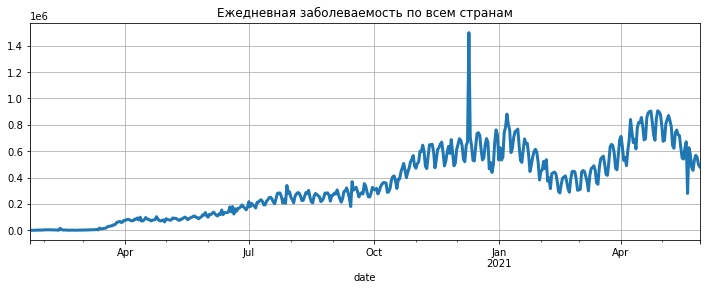

In [31]:
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind = 'line',
    figsize = (12 ,4),
    title = 'Ежедневная заболеваемость по всем странам',
    grid = True,
    lw = 3
)

<AxesSubplot:title={'center':'Распределение ежедневной заболеваемости'}, ylabel='Frequency'>

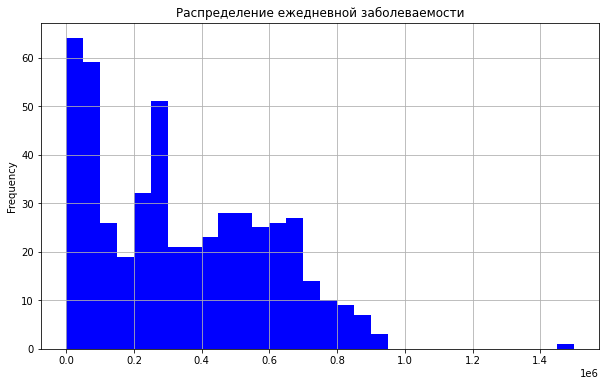

In [34]:
grouped_cases.plot(
    kind = 'hist',
    figsize = (10, 6),
    title = 'Распределение ежедневной заболеваемости',
    grid = True,
    color = 'blue',
    bins = 30
)

Давайте построим столбчатую диаграмму, которая покажет ТОП-10 стран по суммарной заболеваемости.

Для этого сгруппируем данные по странам и вычислим последний зафиксированный показатель с помощью агрегирующего метода last() — он возвращает последнее значение в столбце DataFrame.

Для построения столбчатой диаграммы значение параметра kind выставляем на 'bar'. Параметр colormap отвечает за цветовую гамму графика.

<AxesSubplot:xlabel='country'>

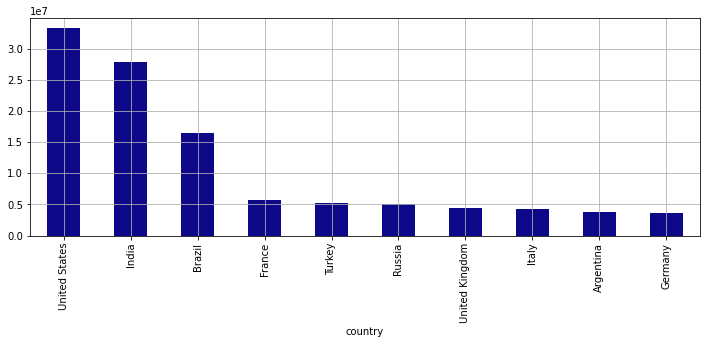

In [35]:
grouped_country = covid_df.groupby(['country'])['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'
)

На диаграмме видно, что лидерами по числу заболевших являются Соединённые Штаты, Индия и Бразилия. Соотношение зафиксированных случаев заражения в остальных странах примерно одинаковое.

А теперь посмотрим, как в этих десяти странах соотносится количество заболевших и умерших от вируса. Для этого отобразим сразу два показателя на столбчатой диаграмме: 

<AxesSubplot:xlabel='country'>

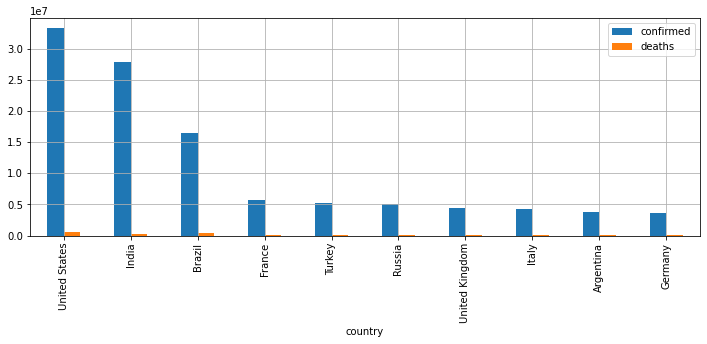

In [36]:
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['confirmed'])
grouped_country.plot( 
    kind='bar', 
    grid=True, 
    figsize=(12, 4), 
)

<AxesSubplot:xlabel='country'>

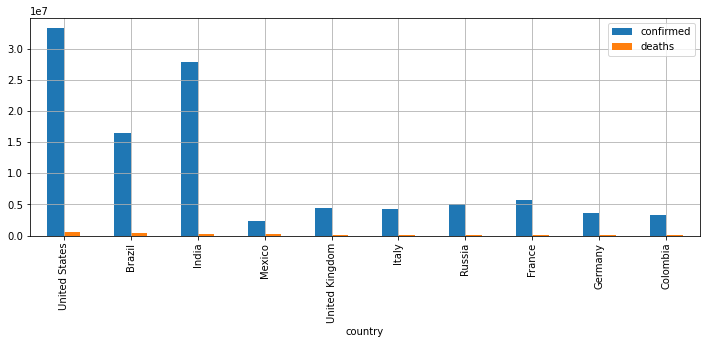

In [37]:
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['deaths'])
grouped_country.plot( 
    kind='bar', 
    grid=True, 
    figsize=(12, 4), 
)

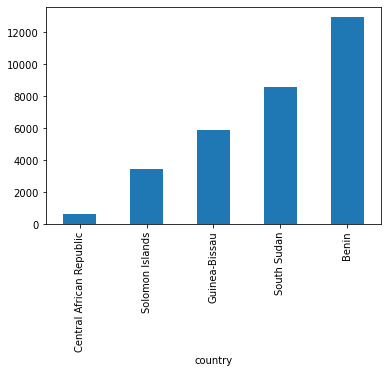

In [38]:
covid_df.groupby(['country'])['total_vaccinations'].last().nsmallest(5).plot(kind='bar');